# Genie: 蛋白质从头设计演示 (De Novo Protein Design Demo)

本笔记演示了 Genie 模型的完整流程：从训练到采样再到评估。
This notebook demonstrates the complete workflow of the Genie model: from training to sampling and evaluation.

In [10]:
import os
import sys
import glob
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Add current directory to path
sys.path.append(os.getcwd())

from genie.config import Config
from genie.utils.model_io import load_model

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


## 2. 训练 (Training)

如果你想从头训练一个新模型，可以使用 `train.py`。
If you want to train a new model from scratch, you can use `train.py`.

训练过程通常需要你自行在终端运行，因为它涉及到分布式训练（多GPU）和长时间运行。
Training is typically run in a terminal as it involves distributed training (multi-GPU) and long runtimes.

以下是启动训练的命令示例：
Here is an example command to start training:

In [ ]:
#To train a new model (Command to run in terminal):
python genie/train.py --config example_configuration --gpus 0,1

# 配置文件定义了超参数。详情请查看 genie/config.py
# Configuration files define hyperparameters. See genie/config.py for details.

## 3. 准备预训练权重 (Prepare Pre-trained Weights)

如果你不进行训练，而是使用提供的预训练权重进行采样，请继续此步骤。
If you are skipping training and using provided pre-trained weights for sampling, proceed with this step.

提供的权重文件结构是扁平的。采样脚本需要特定的目录层级 (`runs/<model_name>/version_<X>/checkpoints/`)。我们将创建一个临时的 `runs` 目录并正确链接权重。
The provided weights are in a flat structure. The sampling script expects a specific directory hierarchy (`runs/<model_name>/version_<X>/checkpoints/`). We will create a temporary `runs` directory and link the weights correctly.

In [12]:
def setup_weights(source_path, model_name, target_root='runs', version=0):
    """
    Restructures weights from source_path to target_root compatible with Genie's loader.
    """
    
    # Target paths
    run_dir = os.path.join(target_root, model_name)
    version_dir = os.path.join(run_dir, f'version_{version}')
    ckpt_dir = os.path.join(version_dir, 'checkpoints')
    
    # Create directories
    os.makedirs(ckpt_dir, exist_ok=True)
    
    # 1. Copy/Link Configuration
    src_config = os.path.join(source_path, 'configuration')
    dst_config = os.path.join(run_dir, 'configuration')
    if os.path.exists(src_config) and not os.path.exists(dst_config):
        shutil.copy(src_config, dst_config)
        print(f"Copied configuration to {dst_config}")
        
    # 2. Link Checkpoint
    # Find .ckpt file in source
    ckpts = glob.glob(os.path.join(source_path, '*.ckpt'))
    if not ckpts:
        raise FileNotFoundError(f"No .ckpt files found in {source_path}")
    
    src_ckpt = ckpts[0] # Take the first one found
    ckpt_name = os.path.basename(src_ckpt)
    dst_ckpt = os.path.join(ckpt_dir, ckpt_name)
    
    if not os.path.exists(dst_ckpt):
        # Use symlink if possible, else copy
        try:
            os.symlink(os.path.abspath(src_ckpt), dst_ckpt)
            print(f"Symlinked checkpoint to {dst_ckpt}")
        except OSError:
            shutil.copy(src_ckpt, dst_ckpt)
            print(f"Copied checkpoint to {dst_ckpt}")

# Define model to use
MODEL_NAME = 'scope_l_128'
WEIGHTS_PATH = os.path.join('weights', MODEL_NAME)

# Set up the folder structure
setup_weights(WEIGHTS_PATH, MODEL_NAME)

## 4. 采样 (Sampling)

现在我们加载模型并生成一些蛋白质骨架结构。
作为示例，我们将生成长度为 64 的蛋白质。

Now we load the model and generate some protein backbone structures.
We will generate proteins of length 64 as an example.

In [14]:
# Configuration for sampling
MODEL_VERSION = 0 # As set up above
ROOT_DIR = 'runs'
BATCH_SIZE = 1 # Number of samples per batch
NOISE_SCALE = 1.0 # Standard deviation of noise
LENGTH = 64 # Residue length to sample

# Reload model_io to ensure fixes are applied without restarting kernel
import importlib
import genie.utils.model_io
importlib.reload(genie.utils.model_io)
from genie.utils.model_io import load_model

# Load Model
# Note: Providing epoch=None loads the latest, which we set up.
model = load_model(ROOT_DIR, MODEL_NAME, MODEL_VERSION).to(device)
model.eval()

print(f"Model {MODEL_NAME} loaded successfully.")

# Setup Output Directory
out_dir = os.path.join('outputs', 'demo_samples')
os.makedirs(out_dir, exist_ok=True)

# Sampling Loop
print(f"Sampling {BATCH_SIZE} structure(s) of length {LENGTH}...")

# Create mask: [Batch, MaxRes]
# Model expects max_n_res sized mask usually, but checks sample loop
max_n_res = model.config.io['max_n_res']
mask = torch.cat([
    torch.ones((BATCH_SIZE, LENGTH)),
    torch.zeros((BATCH_SIZE, max_n_res - LENGTH))
], dim=1).to(device)

with torch.no_grad():
    # p_sample_loop returns a list of intermediate states. The last one is the final sample.
    # [-1] fetches the last step
    ts = model.p_sample_loop(mask, NOISE_SCALE, verbose=True)[-1]
    
    # Save samples
    saved_files = []
    for i in range(ts.shape[0]):
        coords = ts[i].trans.detach().cpu().numpy()
        coords = coords[:LENGTH] # Truncate to actual length
        
        filepath = os.path.join(out_dir, f'sample_{LENGTH}_{i}.npy')
        np.savetxt(filepath, coords, fmt='%.3f', delimiter=',')
        saved_files.append(filepath)
        print(f"Saved: {filepath}")

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint runs/scope_l_128/version_0/checkpoints/epoch=49999.ckpt`


Loading checkpoint from: runs/scope_l_128/version_0/checkpoints/epoch=49999.ckpt
Model scope_l_128 loaded successfully.
Sampling 1 structure(s) of length 64...


sampling loop time step: 100%|██████████| 1000/1000 [06:06<00:00,  2.73it/s]

Saved: outputs/demo_samples/sample_64_0.npy


## 5. 可视化 (Visualization)

通过 Matplotlib 可视化生成的 C-alpha 骨架。

Visualize the generated C-alpha backbone.

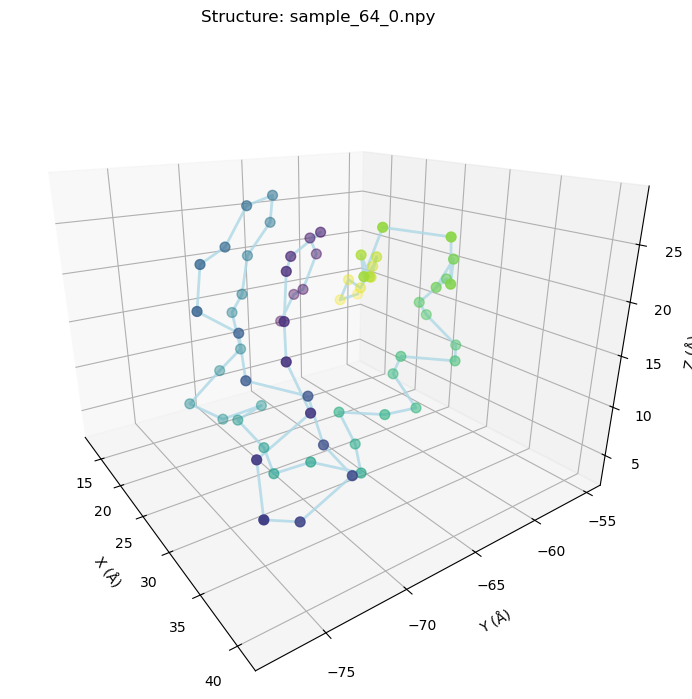

In [15]:
# Simple visualizations using Matplotlib
from mpl_toolkits.mplot3d import Axes3D

def plot_structure(filepath):
    coords = np.loadtxt(filepath, delimiter=',')
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_proj_type('persp', focal_length=0.2)
    
    xs = coords[:, 0]
    ys = coords[:, 1]
    zs = coords[:, 2]
    
    # Draw backbone
    ax.plot(xs, ys, zs, c='lightblue', linewidth=2, label='Backbone', alpha=0.8)
    ax.scatter(xs, ys, zs, c=np.arange(len(xs)), cmap='viridis', s=50, depthshade=True)
    
    ax.set_xlabel('X (Å)')
    ax.set_ylabel('Y (Å)')
    ax.set_zlabel('Z (Å)')
    ax.set_title(f'Structure: {os.path.basename(filepath)}')
    
    # View angle
    ax.view_init(elev=20., azim=-35)
    plt.show()

# Visualize the first sample
if saved_files:
    plot_structure(saved_files[0])

## 6. 评估与分析 (Evaluation & Analysis)

本仓库提供工具来评估生成结构的创新性并分析其属性。
The repository provides tools to evaluate the novelty of generated structures and analyze their properties.

### 质量评估 (Quality Evaluation - scTM & pLDDT)

在分析结果之前，我们需要评估生成骨架的质量（可设计性）。评估流程使用 ProteinMPNN 进行序列设计，使用 ESMFold 进行结构预测，从而计算自洽 TM-score (scTM) 和 pLDDT。
Before analyzing the results, we need to evaluate the quality of the generated backbones (designability). The evaluation pipeline uses ProteinMPNN for sequence design and ESMFold for structure prediction to compute the self-consistency TM-score (scTM) and pLDDT.

此步骤生成后续绘图所需的 `info.csv` 文件。
This step generates the `info.csv` file needed for subsequent plots.

**注意：** 此步骤需要 GPU，并且根据样本数量可能需要一些时间。
**Note:** This step requires a GPU and may take some time depending on the number of samples.

In [ ]:
# To run the Quality Evaluation pipeline (ProteinMPNN + ESMFold):
python evaluations/pipeline/evaluate.py --input_dir outputs/demo_samples --output_dir outputs/demo_samples/evaluations

### 创新性评估 (Novelty Evaluation)

你可以通过使用 TM-score 将生成的蛋白质与参考数据库（如 PDB）进行比较，来评估其“创新性”。
You can evaluate how "novel" your generated proteins are by comparing them against a reference database (e.g., PDB) using TM-score.

提供了两个脚本：
There are two provided scripts:
1. `Novelty_Evaluation_CPU.py`: 穷举搜索（较慢，精确）。Exhaustive search (slower, exact).
2. `Novelty_Evaluation_GPU.py`: 使用嵌入进行快速筛选的混合搜索（较快）。Hybrid search using embeddings for fast screening (faster).

**使用示例 (生成命令):**
下面的单元格生成你将在终端运行的命令。注意，你需要安装参考数据库（例如 `data/pdbstyle-2.08`）才能使其工作。
The following cell generates the commands you would run in a terminal. Note that you need a reference database (e.g., `data/pdbstyle-2.08`) installed for these to work.

In [ ]:
# To run CPU-based Novelty Evaluation:
python evaluations/Novelty_Evaluation_CPU.py --input_dir outputs/demo_samples/evaluations --ref_dir data/pdbstyle-2.08 --num_workers 4

# To run GPU-based Novelty Evaluation:
python evaluations/Novelty_Evaluation_GPU.py --input_dir outputs/demo_samples/evaluations

### 分析绘图 (Analysis Plotting)

一旦你有了评估结果（例如来自评估流程的 `info.csv` 或来自上述脚本的 `novelty.csv`），你就可以生成分析图表。
Once you have evaluation results (e.g., `info.csv` from the evaluation pipeline or `novelty.csv` from the scripts above), you can generate analysis plots.

1. **MDS 图 (MDS Plot)**: 可视化设计空间。Visualizes the design space.
2. **综合分析 (General Analysis)**: 绘制 pLDDT 与 scTM 关系，SSE 分布等。Plots pLDDT vs scTM, SSE distribution, etc.

In [ ]:
# To plot Design Space MDS:
python evaluations/plot_genie_mds_novelty.py --input_dir outputs/demo_samples/evaluations --output_file mds_plot.png

# To generate General Analysis Plots:
python evaluations/plot_genie_analysis.py --input_dir outputs/demo_samples/evaluations --output_file analysis_plot.png